In [770]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [771]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [772]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "BHL10"

In [773]:
from typing import List, Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
import operator

In [774]:
class MainAction(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action"] = Field(description="Next action to execute in mission planning phase")
    messages: str

class Asteroid(BaseModel):
    Name: str
    OCC:str
    Diameter: str
    TOF: str
    Launch_date: str
    Min_dv: str
    Duration: str
    Stay: str
    Class: str
    @property
    def asteroid(self) -> str:
        return f"Name: {self.name}\nOCC: {self.OCC}\nDiameter: {self.Diameter}\nTOF: {self.TOF}\nLaunch_date: {self.Launch_date}\nMin_dv: {self.Min_dv}\nDuration: {self.Duration}\nStay: {self.Stay}\nClass: {self.Class}\n"
    
class Asteroids(BaseModel):
    Asteroids: List[Asteroid] = Field(
        description="Comprehensive list of asteroids for mission.",
    )
class MissionState(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action"] = Field(description="Next action to execute in mission planning phase")
    asteroids: Annotated[list, operator.add] = Field(description = "Potential destinations for mission")
    spacecraft: Annotated[list, operator.add] = Field(description = "List of potential spacecrafts for mission")
    time: Annotated[list, operator.add] = Field(description="Time windows to start mission")
    cost: Annotated[list, operator.add] = Field(description="Cost of mission based on asteroids and spacecrafts")
    messages: Annotated[list, operator.add]
    table: str
    # analysts: List[Analyst]
    # messages: Annotated[list[AnyMessage], add_messages]
    # messages: list[AnyMessage]

class MissionState2(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action"] = Field(description="Next action to execute in mission planning phase")
    # asteroids: list = Field(description = "Potential destinations for mission")
    # spacecraft: list = Field(description = "List of potential spacecrafts for mission")
    # time: list = Field(description="Time windows to start mission")
    # cost: list = Field(description="Cost of mission based on asteroids and spacecrafts")
    messages: str = Field(description="Your question to experts about specific informations")

class text2sqlState(TypedDict):
    next_action: Literal["mission_planner","text2sql"] = Field(description="Next action to execute in mission planning phase")
    asteroids: list = Field(description = "Potential destinations for mission")
    time: list = Field(description="Time windows to start mission")
    messages: str
    table: str
# class ResearchGraphState(TypedDict):
#     topic: str # Research topic
#     max_analysts: int # Number of analysts
#     human_analyst_feedback: str # Human feedback
#     analysts: List[Analyst] # Analyst asking questions
#     sections: Annotated[list, operator.add] # Send() API key
#     introduction: str # Introduction for the final report
#     content: str # Content for the final report
#     conclusion: str # Conclusion for the final report
#     final_report: str # Final report

# class MissionState(MessagesState):
#     next_action: Literal["file_summary","final_raport"] = Field(description="Next action to execute")
#     file: str = Field(description="If next action is 'file_summary' name of a file to summary")

In [775]:
import re
import sqlite3

text2sql_prompt = """You are expert in writing sql queries for retrieving most well fited dataset to user query.

Use {table}. Limit answers to 5 rows.

{table} schema:

Spkid INTEGER NOT NULL -- Small-Body Perturbation Kernel Identifier.
Surname TEXT NOT NULL -- Catalogue Name of Asteroid.
Name TEXT -- Common Name of Asteroid (not everyone has it).
OCC INTEGER NOT NULL -- Orbit condition code, defines the asteroid’s orbit accuracy where 0 implies a well-determined orbit and 9 implies a very poorly-determined (highly uncertain) orbit.
Diameter REAL NOT NULL -- Mean Diameter in kilometers.
TOF REAL NOT NULL -- Time Of Flight to asteroid estimated for mission.
Launch_date DATE NOT NULL -- Date of Launch for mission.
Min_dv REAL NOT NULL -- Minimal requirement delta of Velocity.
Duration INTEGER NOT NULL -- Expected Duration of a whole mission.
Stay INTEGER NOT NULL -- How many days can mission stay for mining at asteroid.
Class TEXT NOT NULL -- Class of asteroid

User message:
{message}

Extract Name, OCC, Diameter, TOF, Launch_date, Min_dv, Duration, Stay, Class"""

def query_database(table: str, message: str) -> str:
    """ Function to retrieve data from database.

    Args:
        table: name of table to extract from.
        message: information that need to be retrieved from database"""
    text2sql_complete = text2sql_prompt.format(table=table,message=message)
    code = llm.invoke(text2sql_complete)
    match = re.search(r"SQL\n(.*?)\n", code.content, re.DOTALL)
    print(match)
    return match

tools = [query_database]

In [776]:
from datetime import datetime

planner_prompt = """You are an expert in planning missions for asteroids mining.
Your goal is to plan best scenarios for those missions (minimize risk of failure and maximize profit with time and cost optimization).

You can take specific actions:
1) Recive information from expert from specific field
2) Write mission summary based on gatherd information

In your dispostion are 4 experts which are source of information:
1) Spacecraft Manager
2) Cost planner
3) Time planner
4) Asteroids expert

You need to gather information from all fields to produce mission summary scenarios.
If you decided that you have sufficient information form sepcific field proceed to another.

Asteroid info:
{asteroids}
"""

planner_prompt = """Role Description:
You are an expert in planning asteroid mining missions. Your primary objective is to design the best possible mission scenarios that minimize risk of failure while maximizing profit through optimal time and cost management.

Capabilities and Actions:
You can perform the following actions:

1. Gather Information: Request and receive detailed input from domain experts in specific fields.
2. Create Mission Summary: Compile and synthesize the gathered information into comprehensive mission scenarios.

Resources at Your Disposal:
You have access to four domain experts, each specializing in a key area:

1. Spacecraft Manager: Provides details on spacecraft design, functionality, and limitations.
2. Cost Planner: Supplies insights into budget allocations, expenses, and cost-saving opportunities.
3. Time Planner: Offers strategies for scheduling and minimizing delays.
4. Asteroid Expert: Delivers critical data on asteroid type, trajectories, and mining potential.

Process:

- You must gather information from all four experts to develop a complete mission summary.
- Once you determine you have sufficient details from one field, move on to the next expert until all necessary data is collected.
- Don't ask one expert many times in a row
- Use this comprehensive knowledge to formulate mission scenarios that optimize risk, cost, and time considerations.

Current Asteroid Information:
{asteroids}
"""
# Asteroids:
# {asteroids}

# Spacecrafts:
# {spacecrafts}

# Costs:
# {costs}

def planner(state: MissionState):
    structured_llm = llm.with_structured_output(MissionState2)
    # action = structured_llm.invoke([SystemMessage(content=planner_prompt)]+[HumanMessage(content="Plan a mission for asteroid mining for closest asteroids.")])
    if len(state["asteroids"]) >=1:
        list_asteroids = "\n".join(state["asteroids"])
    else:
        list_asteroids = []
    planner_complete = planner_prompt.format(asteroids=list_asteroids)
    action = structured_llm.invoke([SystemMessage(content=planner_complete)]+state["messages"])
    print(action)
    return {"next_action": action["next_action"],
            "messages":[action["messages"]],
            # "spacecraft":action["spacecraft"],
            # "time":action["time"],
            # "cost":action["cost"]
            }

asteroids_prompt = """You are an expert from asteroids field.
Your goal is to give answers about specific asteroids objects based on knwoledge from database.
First you need to query database to gather information ONLY ONCE. Table which contains asteroids is named 'asteroids'.

Write message about type of asteroids you want to extract information about.

Asteroids:
{asteroids}

Then you have to interperet which of those are best for mission.
"""

def asteroids_expert(state: MissionState):
    structured_llm = llm.with_structured_output(text2sqlState)
    list_asteroids = "\n".join(state["asteroids"])
    asteroids_complete = asteroids_prompt.format(asteroids=list_asteroids)
    answer = structured_llm.invoke([SystemMessage(content=asteroids_complete)]+state["messages"])
    print(answer)
    if answer["next_action"]=="mission_planner":
        return {"next_action":answer["next_action"],"messages":[list_asteroids]}
    else:
        return {"next_action":answer["next_action"],"table":answer["table"],"messages":[answer["messages"]]}

def text2sql(state: text2sqlState):
    table = state["table"]
    message = state["messages"][-1]
    text2sql_complete = text2sql_prompt.format(table=table,message=message)
    code = llm.invoke(text2sql_complete)
    print(code)
    match = match = re.search(r"```.*?\n(.*?)\n```", code.content, re.DOTALL)
    sql_code = match.group(1)
    print(sql_code)
    conn = sqlite3.connect("database2.db")
    cursor = conn.cursor()
    cursor.execute(sql_code)
    ans = cursor.fetchall()
    print(ans)
    conn.close()

    formatted_data = []
    for row in ans:
        name, occ, diameter, tof, launch_date, min_dv, duration, stay, asteroid_class = row
        formatted_data.append(f"""- Name: {name if name else "Unknown"}
- Orbit Condition Code (OCC): {occ}
- Diameter: {diameter:.2f} km
- Time of Flight (TOF): {tof:.1f} days
- Launch Date: {datetime.strptime(launch_date, '%Y-%m-%d %H:%M:%S').date()}
- Minimal Delta-V (Min_dv): {min_dv:.2f} km/s
- Mission Duration: {duration} days
- Mining Stay: {stay} days
- Class: {asteroid_class}

""")

    if state["table"]=="asteroids":
        return {"asteroids":formatted_data, "next_action":"asteroids_action"}
    # code = llm.invoke([SystemMessage(content=text2sql_prompt)]+state["messages"][-1])
    # print(code.content)
    else:
        return {"messages":[code.content]}
    # return {"messages":["I propose those asteroids: Celior which is M type asteroid in distance of 1.243 delta v from Earth and Helion which is M type asteroid in distance of 1.5 delta v"], "asteroids":["Celior","Helion"]}

def spacecraft_manager(state: MissionState):
    print("Spaceraft Manager")

def time_planner(state: MissionState):
    pass

cost_prompt = """You are an expert from financial field planning asteroids mining missions.
Your goal is to give answers about costs of mission based on knwoledge about asteroids and spacecrafts.
If you need more information about any of those fields, ask back planner.

Write costs and revenues for provided data.

Asteroids:
{asteroids}

Spacecrafts:
{spacecrafts}
"""

def cost_planner(state: MissionState):
    cost_complete = cost_prompt.format(asteroids=state["asteroids"], spacecrafts = ["spacecrafts"])
    answer = llm.invoke([SystemMessage(content=cost_complete)]+state["messages"])
    print(answer.content)
    return{"messages":answer.content}

def mission_summary(state: MissionState):
    pass

In [777]:
# ans = llm.invoke("What are those parameters in Asteroids data: H    albedo    diameter    i    a    q    e    neo. Describe shortly for text2sql model.")
# print(ans.content)

In [ ]:
def main_stage_condition(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="asteroids_action":
        return "asteroids_expert"
    if action=="spacecraft_action":
        return "spacecraft_manager"
    if action=="cost_action":
        return "cost_planner"
    if action=="time_action":
        return "time_planner"

def spacecraft_condition(state: MissionState):
    pass

In [779]:
def text2sql_condition_return(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="asteroids_action":
        return "asteroids_expert"
    if action=="spacecraft_manager":
        return "spacecraft_manager"
    
def text2sql_condition(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="text2sql":
        return "text2sql"
    else:
        return "mission_planner"

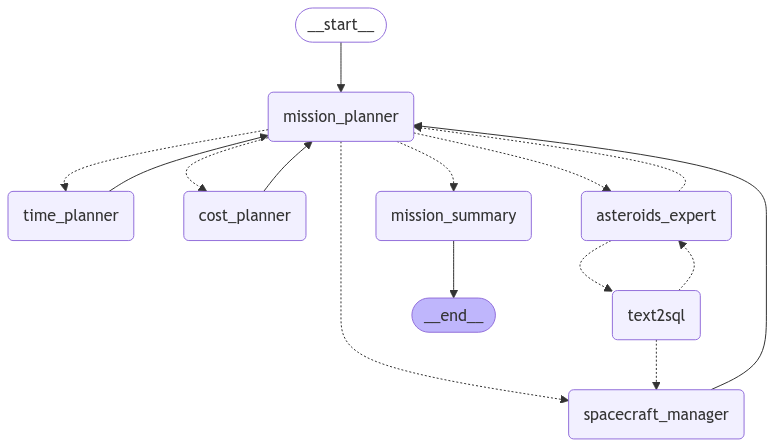

In [780]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MissionState)

# Define nodes: these do the work
builder.add_node("mission_planner",planner)
builder.add_node("spacecraft_manager",spacecraft_manager)
builder.add_node("time_planner",time_planner)
builder.add_node("cost_planner",cost_planner)
builder.add_node("text2sql",text2sql)
builder.add_node("asteroids_expert",asteroids_expert)
builder.add_node("mission_summary",mission_summary)
# builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "mission_planner")
builder.add_conditional_edges("mission_planner",main_stage_condition,["spacecraft_manager","time_planner","cost_planner","mission_summary","asteroids_expert"])
# builder.add_conditional_edges("asteroids_expert",tools_condition,["tools"])
# builder.add_edge("asteroids_expert","mission_planner")
# builder.add_edge("tools","asteroids_expert")
builder.add_conditional_edges("asteroids_expert",text2sql_condition,["text2sql","mission_planner"])
builder.add_conditional_edges("text2sql",text2sql_condition_return,["asteroids_expert","spacecraft_manager"])
# builder.add_edge("spacecraft_manager","text2sql")
# builder.add_edge("cost_planner","text2sql")
# builder.add_edge("text2sql","mission_planner")
# builder.add_edge("text2sql","spacecraft_manager")
# builder.add_edge("text2sql","cost_planner")
# builder.add_edge("spacecraft_manager","mission_planner")
builder.add_edge("time_planner","mission_planner")
builder.add_edge("cost_planner","mission_planner")
builder.add_edge("spacecraft_manager","mission_planner")
builder.add_edge("mission_summary",END)
# builder.add_conditional_edges("spacecraft_manager", spacecraft_condition, ["mission_planner","text2sql"])


# builder.add_conditional_edges("create_analysts", END)
# react_graph = builder.compile()
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [781]:
config = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream({"messages":["Plan an asteroid mining expedition from closest to earth M type asteroids"],"next_action":""},config,stream_mode="values"):
    print(event)
    print("----")

{'next_action': '', 'asteroids': [], 'spacecraft': [], 'time': [], 'cost': [], 'messages': ['Plan an asteroid mining expedition from closest to earth M type asteroids']}
----
{'next_action': 'asteroids_action', 'messages': 'Gather information on the closest M-type asteroids to Earth, including their trajectories, composition, and mining potential.'}
asteroids_action
{'next_action': 'asteroids_action', 'asteroids': [], 'spacecraft': [], 'time': [], 'cost': [], 'messages': ['Plan an asteroid mining expedition from closest to earth M type asteroids', 'Gather information on the closest M-type asteroids to Earth, including their trajectories, composition, and mining potential.']}
----
{'next_action': 'text2sql', 'asteroids': [], 'time': [], 'messages': 'Gathering information on the closest M-type asteroids to Earth, including their trajectories, composition, and mining potential.', 'table': 'asteroids'}
text2sql
{'next_action': 'text2sql', 'asteroids': [], 'spacecraft': [], 'time': [], 'cos

KeyError: None